# Optimization Methods for ML

In [1]:
# some imports
%matplotlib inline

import matplotlib.pyplot as plt

import numpy as np
import scipy.stats as stats
import scipy

# we use theano for grad and hessian computations
import theano
import theano.tensor as T

## Problem

As an example we use two class logistic regression.
Firstly, we generate some normally distributed data with the same convariance matrix and different mean (i.e. ideal for log-regression case).

For simplicity, we generate clasters so that bias term of analytical solution vanishes thus we can consider only
2 variable for optimization, which is essential for visualization.

In [2]:
d1 = stats.multivariate_normal(mean=[-0.5, -0.5], cov=[[0.95, -0.65], [-0.65, 0.94]])
d2 = stats.multivariate_normal(mean=[0.5, 0.5], cov=[[0.95, -0.65], [-0.65, 0.94]])

X = np.vstack([d1.rvs(size=200), d2.rvs(size=200)]).astype('float32')

y = np.hstack([
    np.zeros(200),
    np.ones(200)
]).astype('float32')

In [3]:
grid_x, grid_y = np.mgrid[-3:3:0.05, -3:3:0.05]
L = np.zeros(shape=grid_x.shape)

In [4]:
for i in xrange(grid_x.shape[0]):
    for j in xrange(grid_x.shape[1]):
        L[i, j] = d1.logpdf([grid_x[i, j], grid_y[i, j]]) - d2.logpdf([grid_x[i, j], grid_y[i, j]])

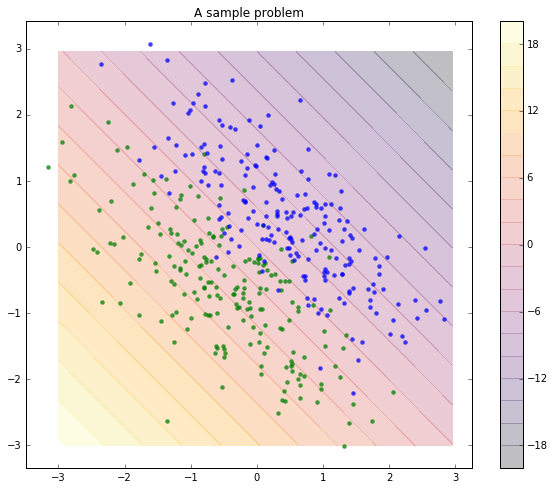

In [5]:
plt.figure(figsize=(10, 8))

plt.title('A sample problem')
cnt = plt.contourf(
    grid_x[:, 0], grid_y[0, :], L,
    cmap=plt.cm.inferno, alpha=0.25, levels=np.linspace(-20, 20, 21)
)

plt.colorbar()

plt.scatter(X[y == 0, 0], X[y == 0, 1], color='green', lw=0, alpha=0.75)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', lw=0, alpha=0.75)

In [6]:
class LogReg(object):
    """
    A container for eesential functions:
     - get_predictions
     - get_loss - objective function
     - get_grad - gradient of objective function
     - get_hessian - Hessian matrix.
    """
    def __init__(self, reg_c=1.0e-3):
        X = T.fmatrix('X')
        y = T.fvector('y')

        w = T.fvector('w')

        p = T.nnet.sigmoid(X.dot(w))

        l = -T.mean((1 - y) * T.log(1 - p) + y * T.log(p)) + reg_c * T.sum(w ** 2)

        dl = theano.grad(l, w)

        Hl = theano.gradient.hessian(l, wrt=w)

        self.get_predictions = theano.function([X, w], p)
        self.get_loss = theano.function([X, y, w], l)

        self.get_grad = theano.function([X, y, w], dl)

        self.get_hessian = theano.function([X, y, w], Hl)
    
    def get_grid(self, X, y, xlims, ylims, steps = 50):
        xs = np.linspace(*xlims, num=steps, dtype='float32')
        ys = np.linspace(*ylims, num=steps, dtype='float32')
        
        L = np.zeros(shape=(steps, steps))
        
        for i in xrange(steps):
            for j in xrange(steps):
                L[i, j] = self.get_loss(X, y, np.array([xs[i], ys[j]]))
        
        return xs, ys, L

In [7]:
lr = LogReg()

print lr.get_loss(X, y, [0.0, 0.0])
print lr.get_grad(X, y, [0.0, 0.0])
print lr.get_hessian(X, y, [0.0, 0.0])

0.693147182465
[-0.24058253 -0.25035214]
[[ 0.30262396 -0.11002537]
 [-0.11002537  0.30098197]]


In [8]:
xs, ys, L = lr.get_grid(X, y, [-2, 10], [-2, 10])

In [9]:
def viz_optimization(opt_result, title='An optimization algorithm', r = 10):
    """
    An utility function for optimization process visualization.
    """
    ls, ws, grads = [np.array(x) for x in zip(*list(opt_result))]
    
    plt.figure(figsize=(5, 5))
    plt.title(title)
    plt.scatter(X[y == 0, 0], X[y == 0, 1], color='green', lw=0, alpha=0.75)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', lw=0, alpha=0.75)
    
    for i in xrange(ws.shape[0]):
        conj = np.array([ws[i, 1], -ws[i, 0]])
        plt.plot(
            [-r * conj[0], r * conj[0]],
            [-r * conj[1], r * conj[1]],
        '--', lw=3, color='black', alpha = float(i) / ws.shape[0])
    
    plt.ylim([-3, 3])
    plt.xlim([-3, 3])
    plt.show()
    
    plt.figure(figsize=(10, 8))
    plt.contour(xs, ys, L, levels=np.linspace(0.0, np.max(L), num=25), cmap=plt.cm.viridis)
    plt.colorbar()
    plt.scatter(ws[:, 0], ws[:, 1], color='blue')
    plt.plot(ws[:, 0], ws[:, 1], lw=1, color='black')
    
    for i in xrange(grads.shape[0]):
        plt.plot(
            [ws[i, 0], ws[i, 0] - 2 * grads[i, 0]],
            [ws[i, 1], ws[i, 1] - 2 * grads[i, 1]],
        '--', color='black')

    plt.show()
    
    plt.figure(figsize=(10, 5))
    plt.title('loss')
    plt.xlabel('step')
    plt.plot(ls)
    plt.show()

## First order methods

In [10]:
def gradient_descent(problem, X, y, initial_guess, learning_rate = 1.0, iters=10):
    w = np.array(initial_guess, dtype='float32')

    l = problem.get_loss(X, y, w)
    grad = problem.get_grad(X, y, w)

    yield l, w, grad

    for i in xrange(iters):
        grad = problem.get_grad(X, y, w)
        w = w - learning_rate * grad
        
        l = problem.get_loss(X, y, w)
        
        yield l, w, grad

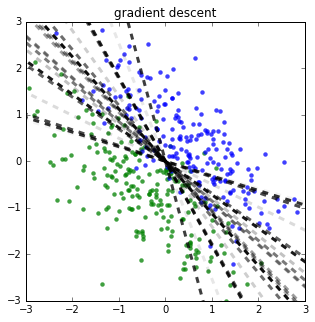

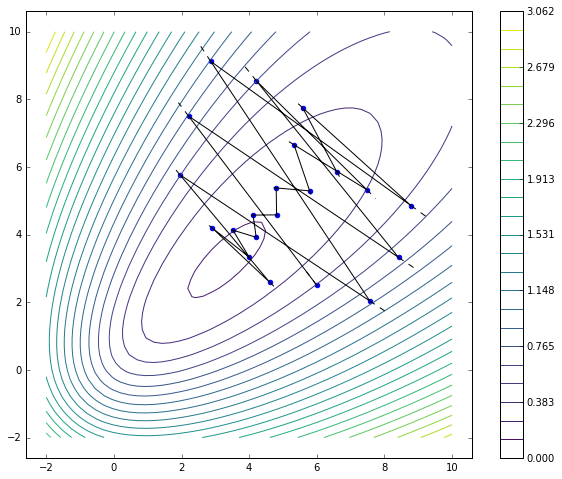

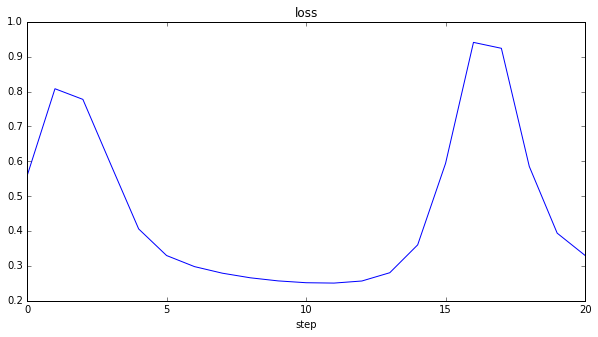

In [11]:
gd_results = gradient_descent(lr, X, y, [6.0, 2.5], learning_rate=25, iters=20)
viz_optimization(gd_results, title='gradient descent')

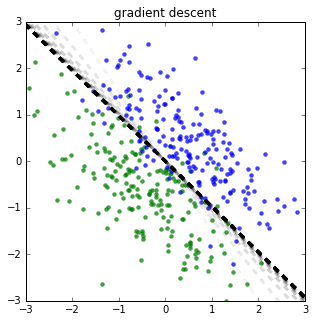

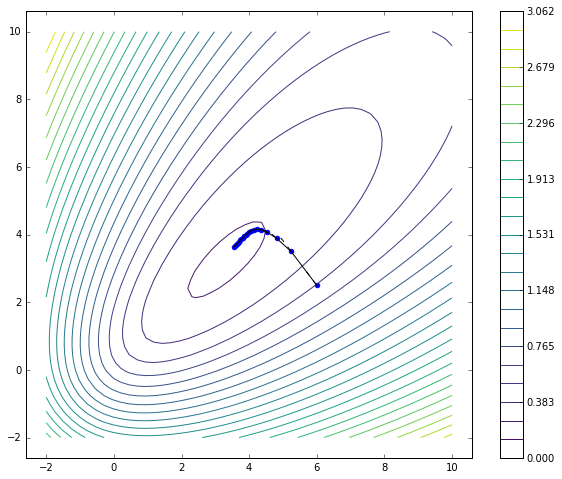

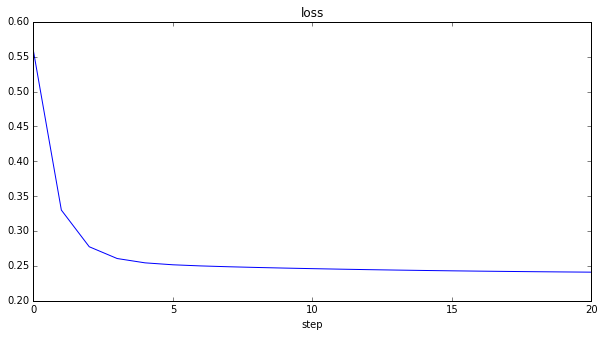

In [12]:
gd_results = gradient_descent(lr, X, y, [6.0, 2.5], learning_rate=5, iters=20)
viz_optimization(gd_results, title='gradient descent')

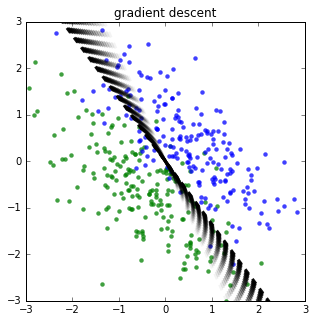

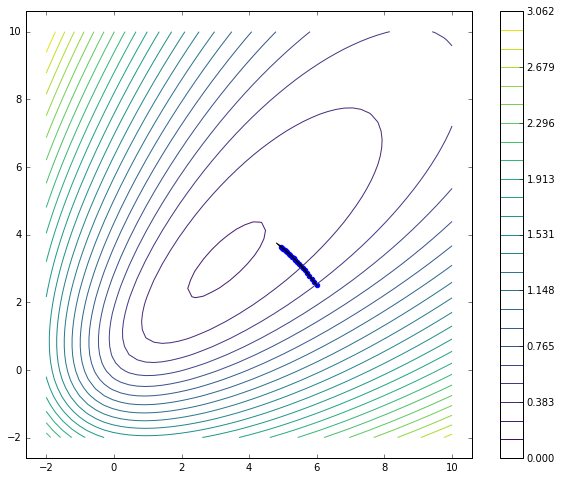

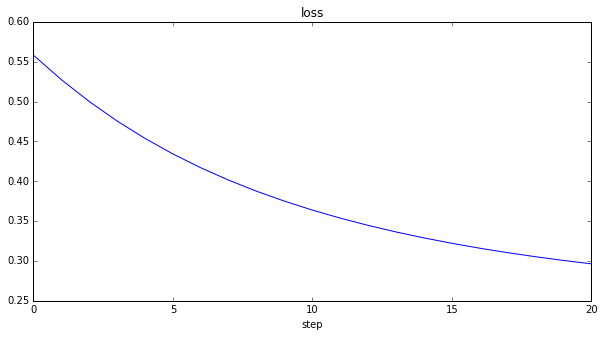

In [13]:
gd_results = gradient_descent(lr, X, y, [6.0, 2.5], learning_rate=0.5, iters=20)
viz_optimization(gd_results, title='gradient descent')

In [14]:
def gradient_descent_with_line_search(problem, X, y, initial_guess, iters=10):
    from scipy.optimize import line_search

    w = np.array(initial_guess, dtype='float32')

    l = problem.get_loss(X, y, w)
    grad = problem.get_grad(X, y, w)

    yield l, w, grad

    for i in xrange(iters):
        grad = problem.get_grad(X, y, w)
        alpha = line_search(
            f = lambda w: problem.get_loss(X, y, w),
            myfprime = lambda w: problem.get_grad(X, y, w),
            xk=w,
            pk=-grad,
            c2 = 0.8
        )[0]

        w = w - alpha * grad
        
        l = problem.get_loss(X, y, w)
        
        yield l, w, grad

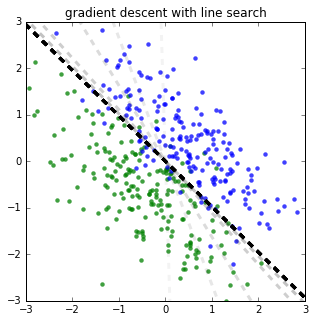

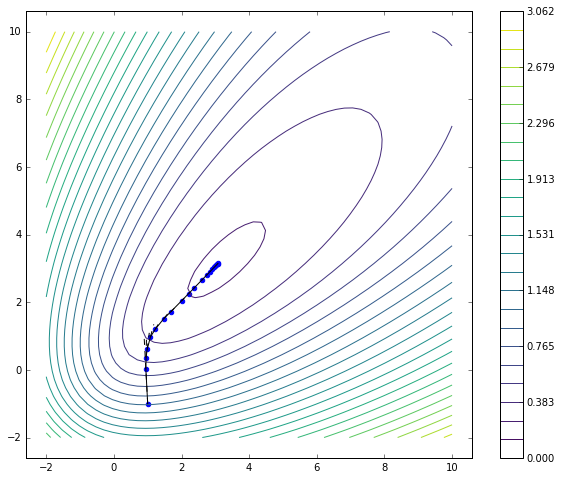

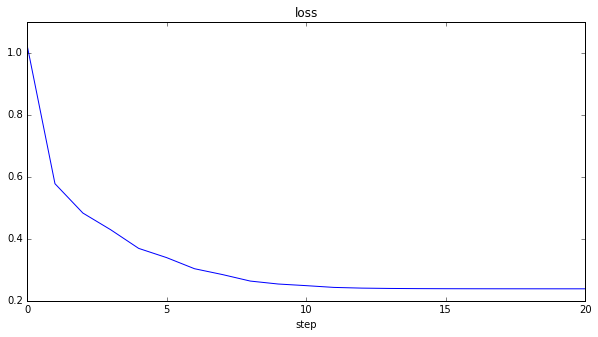

In [15]:
gd_results_ls = gradient_descent_with_line_search(lr, X, y, [1.0, -1.0], iters=20)
viz_optimization(gd_results_ls, title='gradient descent with line search')

In [16]:
def stepest_descent(problem, X, y, initial_guess, bracket_step = 1.0e+2, iters=10):
    from scipy.optimize import minimize_scalar

    w = np.array(initial_guess, dtype='float32')

    l = problem.get_loss(X, y, w)
    grad = problem.get_grad(X, y, w)

    yield l, w, grad

    for i in xrange(iters):
        grad = problem.get_grad(X, y, w)
        alpha = minimize_scalar(
            fun = lambda a: problem.get_loss(X, y, w - a * grad),
            bracket=(0.0, bracket_step)
        ).x

        w = w - alpha * grad
        
        l = problem.get_loss(X, y, w)
        
        yield l, w, grad

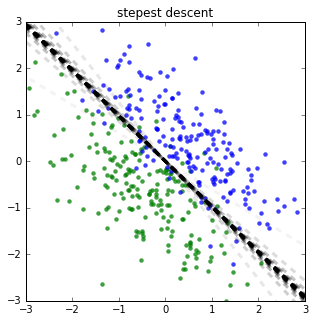

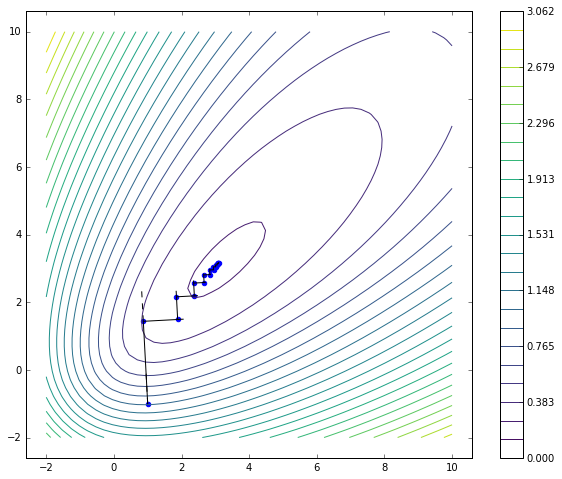

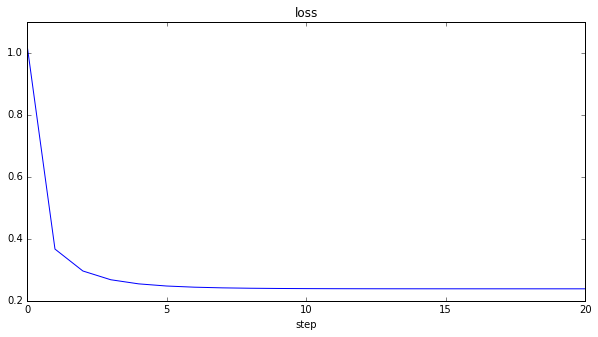

In [17]:
sd_results = stepest_descent(lr, X, y, [1.0, -1.0], iters=20)
viz_optimization(sd_results, title='stepest descent')

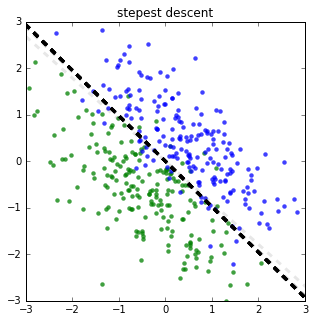

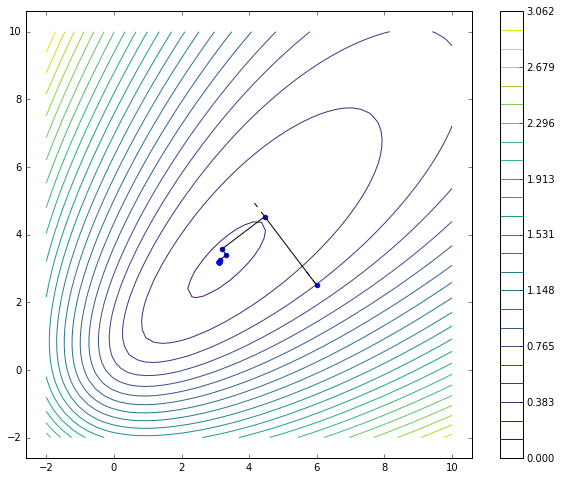

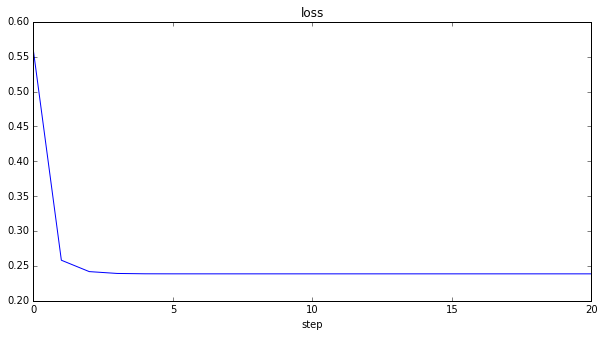

In [18]:
sd_results = stepest_descent(lr, X, y, [6.0, 2.5], iters=20)
viz_optimization(sd_results, title='stepest descent')

In [19]:
def random_descent(problem, X, y, initial_guess, bracket_step = 1.0e+2, iters=10):
    from scipy.optimize import minimize_scalar

    w = np.array(initial_guess, dtype='float32')

    l = problem.get_loss(X, y, w)
    grad = problem.get_grad(X, y, w)

    yield l, w, grad

    for i in xrange(iters):
        grad = np.random.uniform(size=2).astype('float32')

        alpha = minimize_scalar(
            fun = lambda a: problem.get_loss(X, y, w - a * grad),
            bracket=(-bracket_step, bracket_step)
        ).x

        w = w - alpha * grad
        
        l = problem.get_loss(X, y, w)
        
        yield l, w, grad

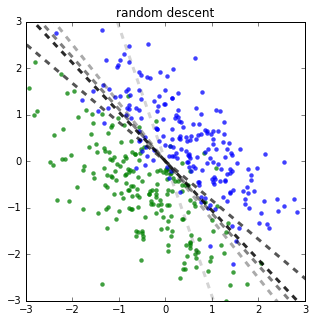

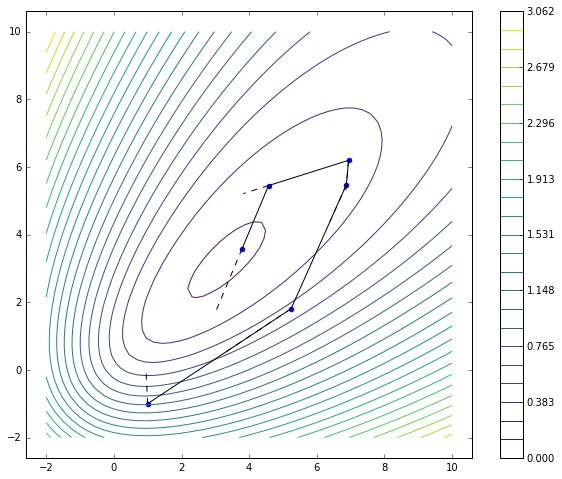

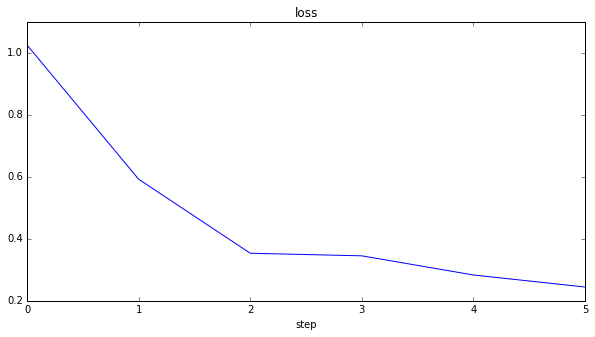

In [20]:
rd_results = random_descent(lr, X, y, [1.0, -1.0], iters=5)
viz_optimization(rd_results, title='random descent')

In [21]:
def sgd(problem, X, y, initial_guess, batch_size=10, learning_rate = 1.0, iters=100):
    from scipy.optimize import minimize_scalar

    w = np.array(initial_guess, dtype='float32')

    l = problem.get_loss(X, y, w)
    grad = problem.get_grad(X, y, w)

    yield l, w, grad

    for i in xrange(iters):
        indx = np.random.choice(X.shape[0], size=batch_size)
        grad = problem.get_grad(X[indx], y[indx], w)

        w = w - learning_rate * grad
        
        l = problem.get_loss(X, y, w)
        
        yield l, w, grad

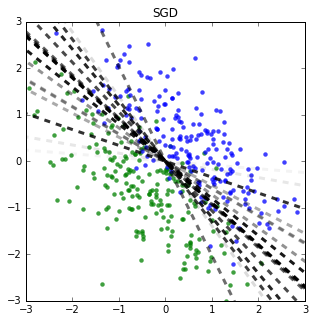

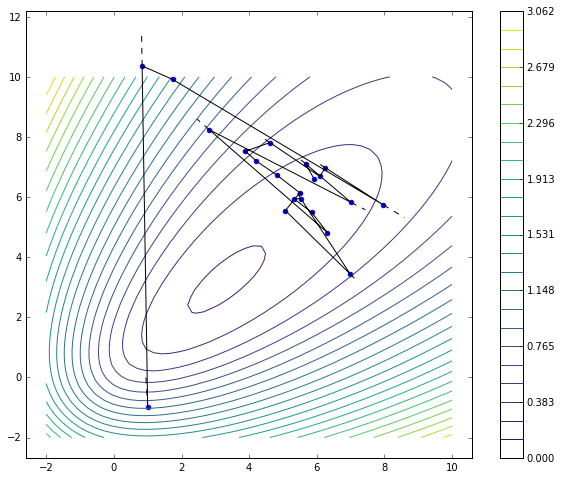

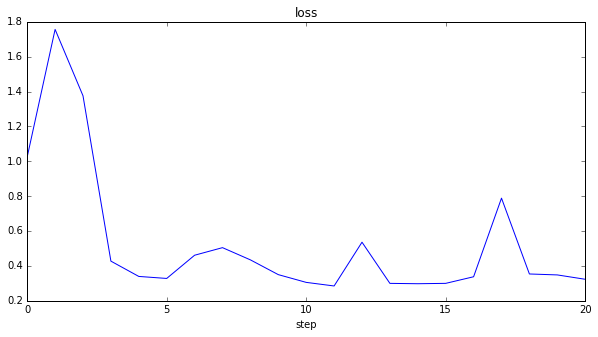

In [22]:
sgd_result = sgd(lr, X, y, [1.0, -1.0], learning_rate=20, iters=20)
viz_optimization(sgd_result, title='SGD')

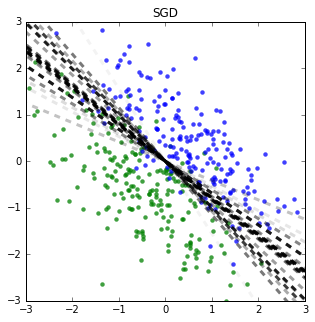

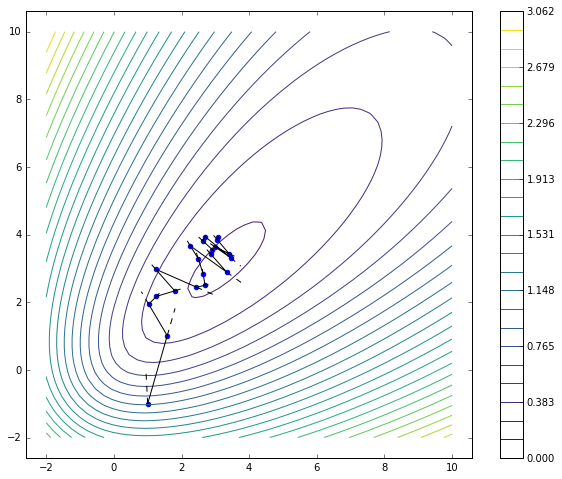

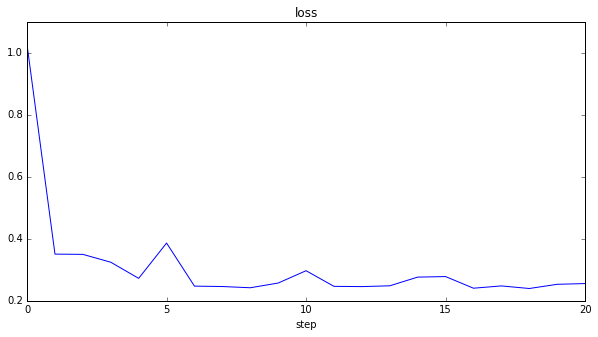

In [23]:
sgd_result = sgd(lr, X, y, [1.0, -1.0], learning_rate=5, iters=20)
viz_optimization(sgd_result, title='SGD')

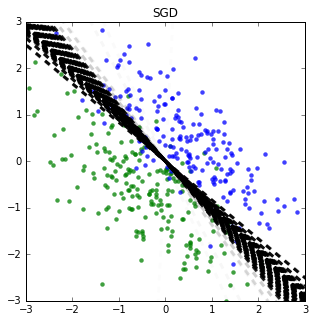

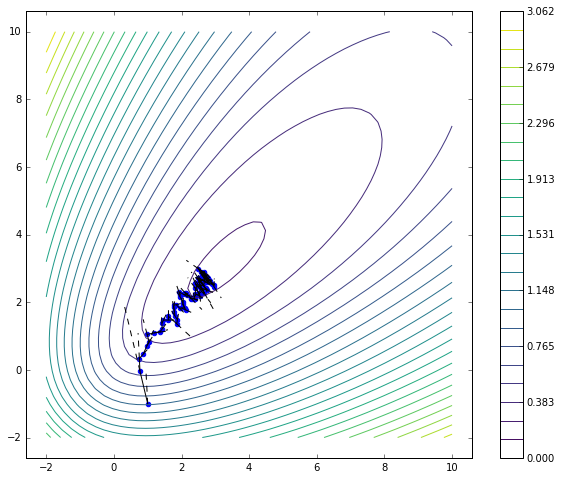

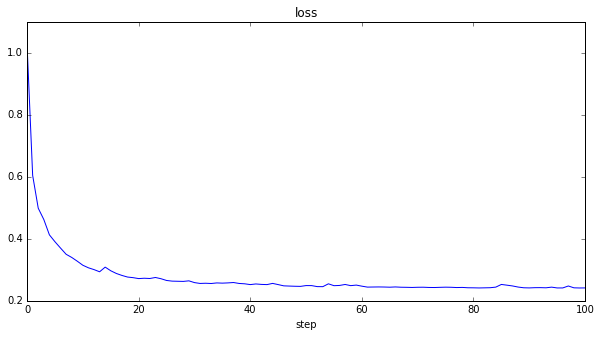

In [24]:
sgd_result = sgd(lr, X, y, [1.0, -1.0], learning_rate=1.0, iters=100)
viz_optimization(sgd_result, title='SGD')

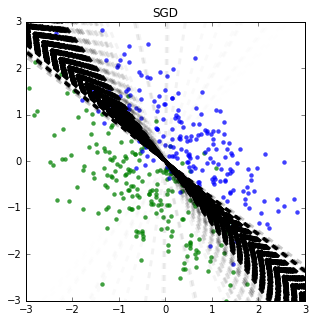

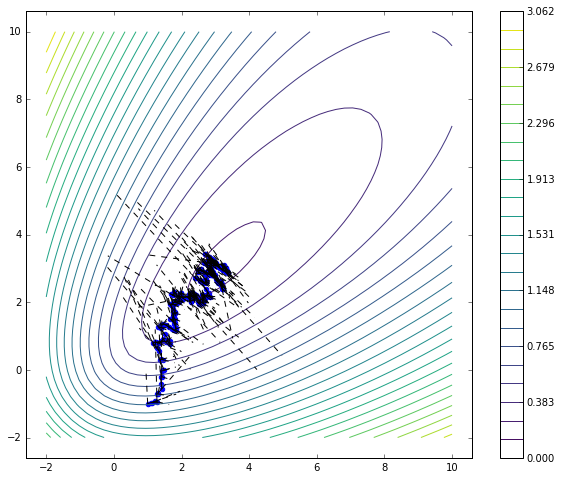

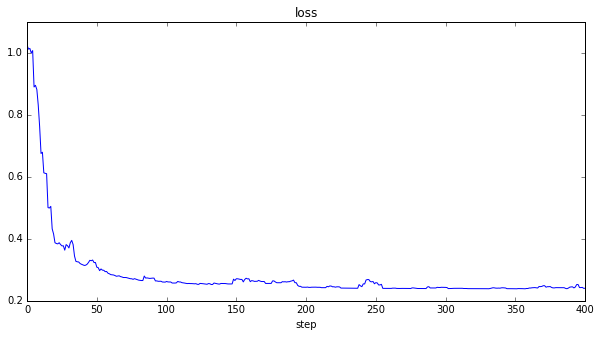

In [25]:
sgd_result = sgd(lr, X, y, [1.0, -1.0], batch_size=1, learning_rate=0.25, iters=400)
viz_optimization(sgd_result, title='SGD')

In [26]:
def sgd_momentum(problem, X, y, initial_guess, batch_size=10, learning_rate = 1.0, rho=0.9, iters=100):
    from scipy.optimize import minimize_scalar

    w = np.array(initial_guess, dtype='float32')

    l = problem.get_loss(X, y, w)
    grad = problem.get_grad(X, y, w)

    yield l, w, grad
    
    v = np.zeros(2, dtype='float32')

    for i in xrange(iters):
        indx = np.random.choice(X.shape[0], size=batch_size)
        grad = problem.get_grad(X[indx], y[indx], w)
        
        v = rho * v - (1 - rho) * grad
        
        w = w + learning_rate * v
        
        l = problem.get_loss(X, y, w)
        
        yield l, w, grad

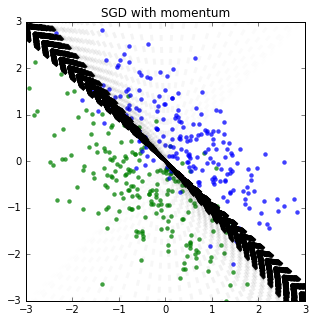

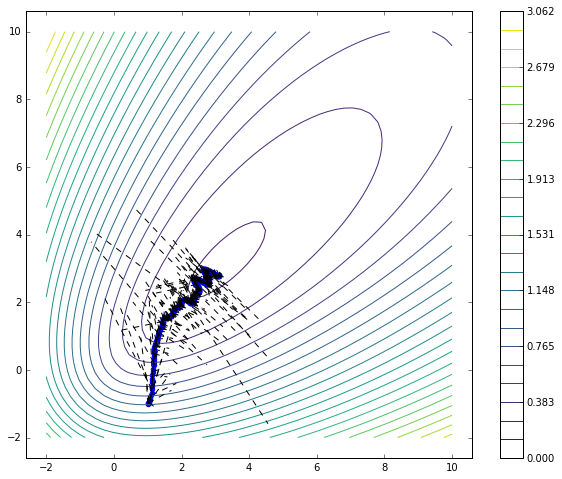

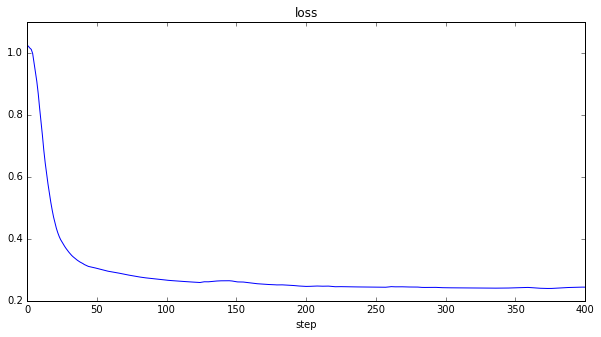

In [27]:
sgd_m_results = sgd_momentum(lr, X, y, [1.0, -1.0], batch_size=1, learning_rate=0.2, iters=400)
viz_optimization(sgd_m_results, title='SGD with momentum')

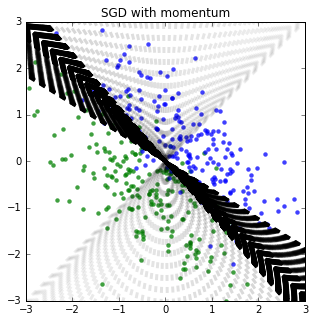

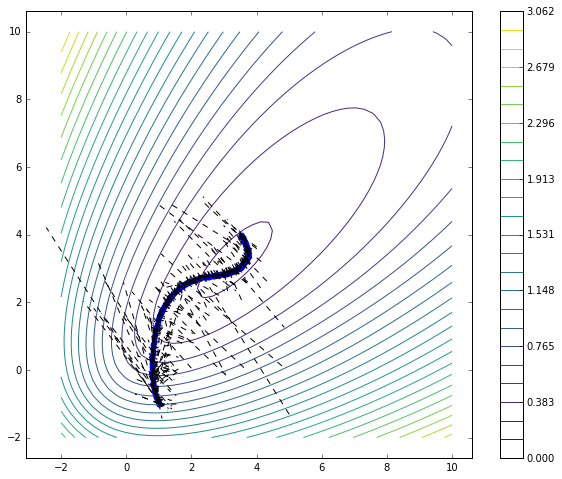

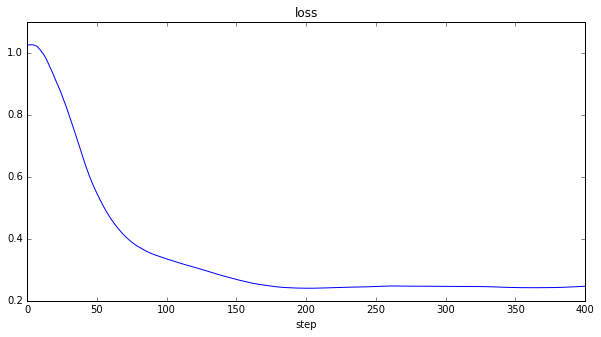

In [28]:
sgd_m_results = sgd_momentum(lr, X, y, [1.0, -1.0], batch_size=1, learning_rate=0.25, rho=0.99, iters=400)
viz_optimization(sgd_m_results, title='SGD with momentum')

In [29]:
def nesterov(problem, X, y, initial_guess, batch_size=10, learning_rate=1.0, rho=0.9, iters=100):
    from scipy.optimize import minimize_scalar

    w = np.array(initial_guess, dtype='float32')

    l = problem.get_loss(X, y, w)
    grad = problem.get_grad(X, y, w)

    yield l, w, grad
    
    v = np.zeros(2, dtype='float32')

    for i in xrange(iters):
        indx = np.random.choice(X.shape[0], size=batch_size)
        grad = problem.get_grad(X[indx], y[indx], w + learning_rate * v)
        
        v = rho * v - (1 - rho) * grad
        
        w = w + learning_rate * v
        
        l = problem.get_loss(X, y, w)
        
        yield l, w, grad

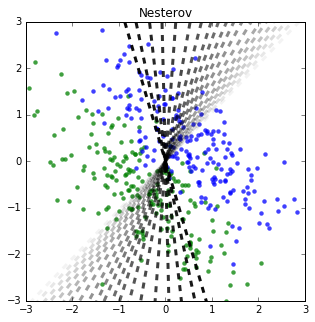

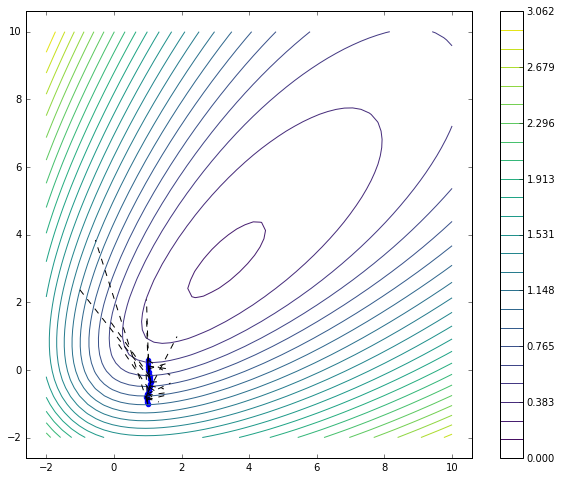

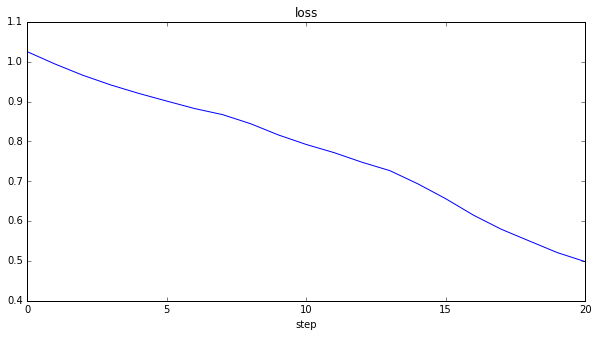

In [30]:
nesterov_result = nesterov(lr, X, y, [1.0, -1.0], batch_size=1, learning_rate=0.25, iters=20)
viz_optimization(nesterov_result, title='Nesterov')

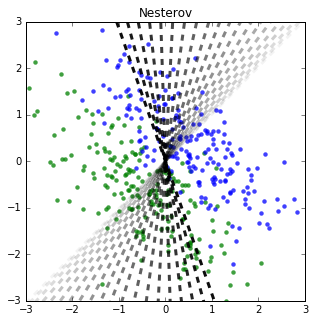

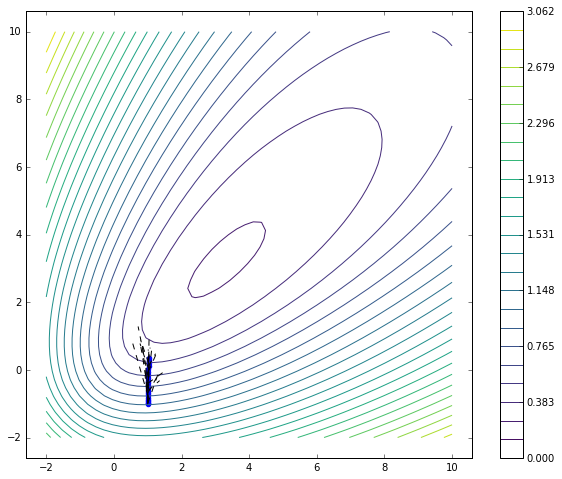

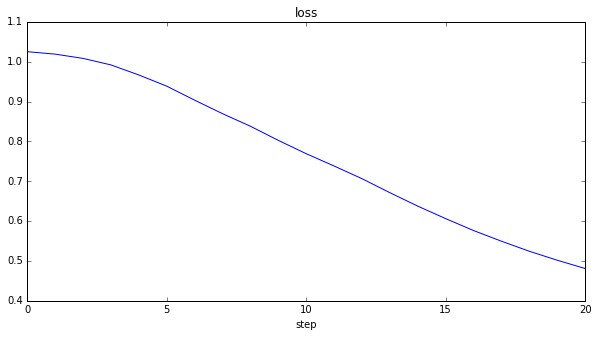

In [31]:
nesterov_result = nesterov(lr, X, y, [1.0, -1.0], batch_size=10, learning_rate=0.25, iters=20)
viz_optimization(nesterov_result, title='Nesterov')

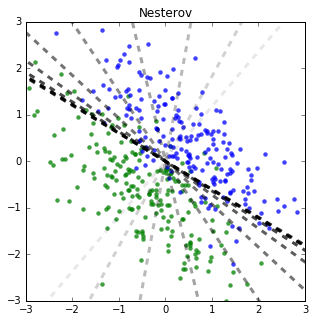

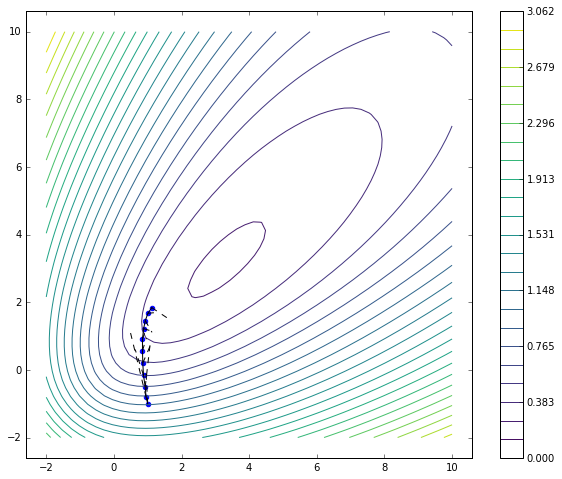

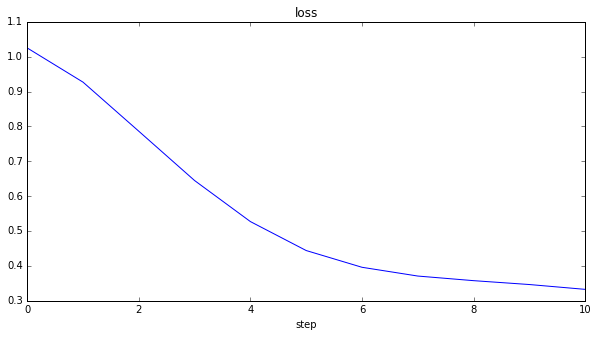

In [32]:
nesterov_result = nesterov(lr, X, y, [1.0, -1.0], batch_size=10, learning_rate=2.0, iters=10)
viz_optimization(nesterov_result, title='Nesterov')

In [33]:
def adagrad(problem, X, y, initial_guess, batch_size=10, learning_rate=1.0, delta=1.0e-3, iters=100):
    from scipy.optimize import minimize_scalar

    w = np.array(initial_guess, dtype='float32')

    l = problem.get_loss(X, y, w)
    grad = problem.get_grad(X, y, w)

    yield l, w, grad
    
    r = np.zeros(2, dtype='float32')

    for i in xrange(iters):
        indx = np.random.choice(X.shape[0], size=batch_size)
        grad = problem.get_grad(X[indx], y[indx], w)
        
        r = r + grad * grad
        
        d = learning_rate / (delta + np.sqrt(r)) * grad
        
        w = w - d
        
        l = problem.get_loss(X, y, w)
        
        yield l, w, grad

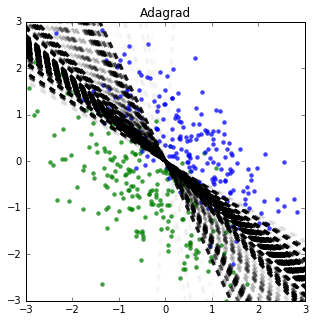

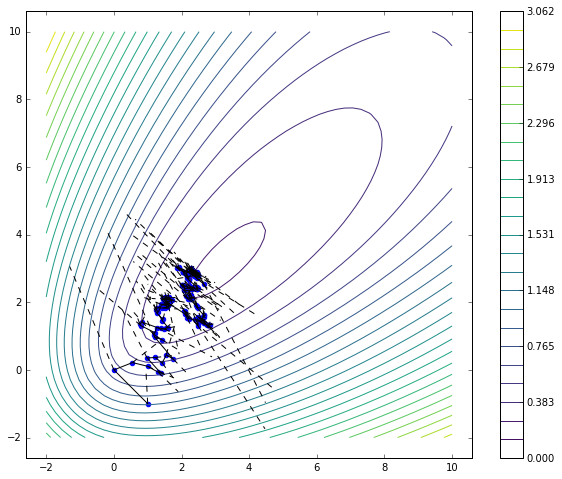

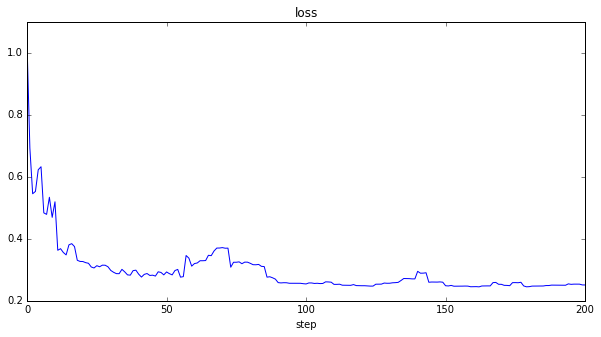

In [34]:
adagrad_result = adagrad(lr, X, y, [1.0, -1.0], batch_size=1, learning_rate=1.0, iters=200)
viz_optimization(adagrad_result, title='Adagrad')

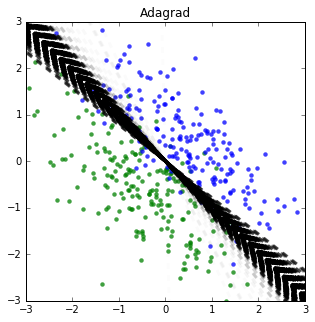

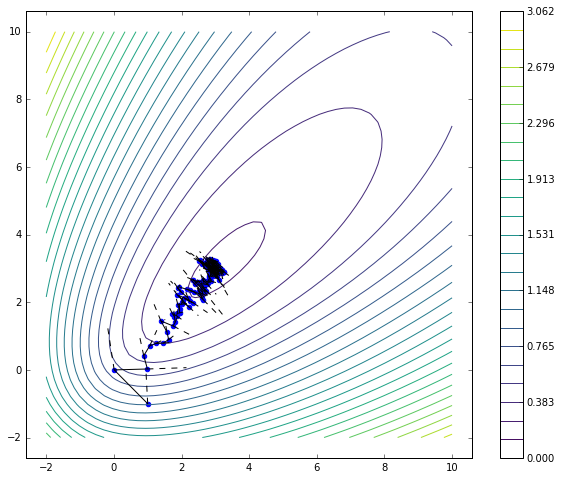

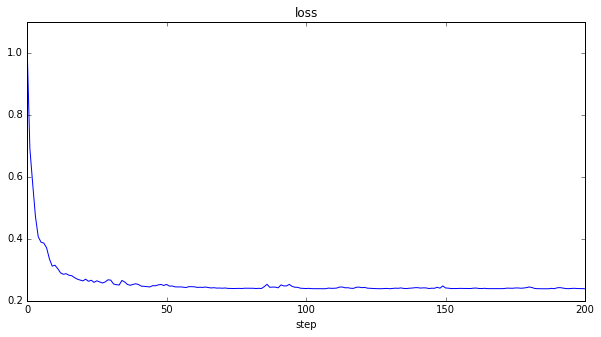

In [35]:
adagrad_result = adagrad(lr, X, y, [1.0, -1.0], batch_size=10, learning_rate=1.0, iters=200)
viz_optimization(adagrad_result, title='Adagrad')

In [36]:
def rmsprop(problem, X, y, initial_guess, batch_size=10, learning_rate=1.0, rho=0.9, delta=1.0e-3, iters=100):
    from scipy.optimize import minimize_scalar

    w = np.array(initial_guess, dtype='float32')

    l = problem.get_loss(X, y, w)
    grad = problem.get_grad(X, y, w)

    yield l, w, grad
    
    r = np.zeros(2, dtype='float32')

    for i in xrange(iters):
        indx = np.random.choice(X.shape[0], size=batch_size)
        grad = problem.get_grad(X[indx], y[indx], w)
        
        r = rho * r + (1 - rho) * grad * grad
        
        d = learning_rate / (delta + np.sqrt(r)) * grad
        
        w = w - d
        
        l = problem.get_loss(X, y, w)
        
        yield l, w, grad

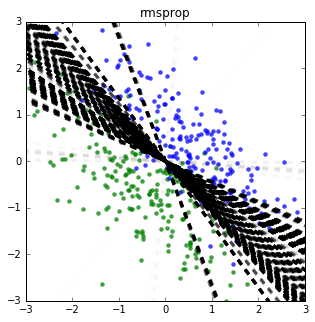

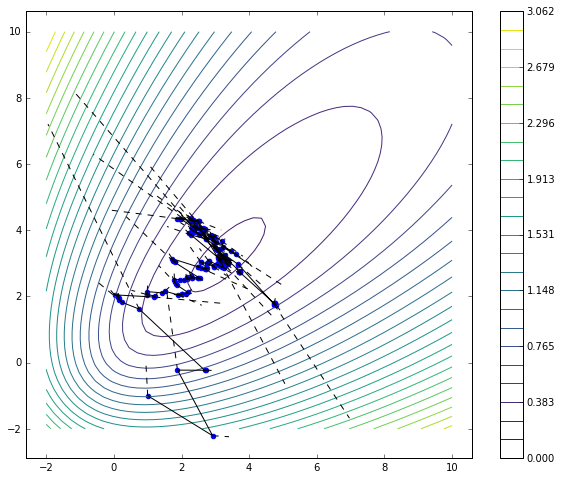

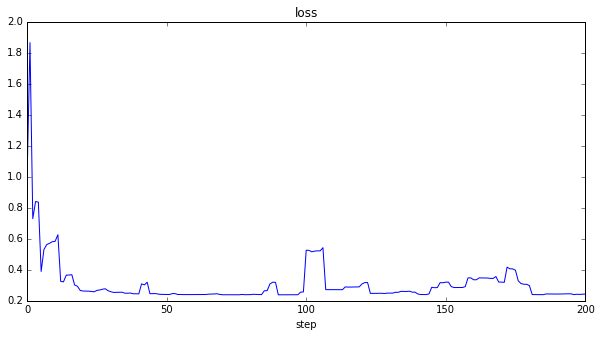

In [37]:
rmsprop_result = rmsprop(lr, X, y, [1.0, -1.0], batch_size=1, learning_rate=0.2, rho=0.99, iters=200)
viz_optimization(rmsprop_result, title='rmsprop')

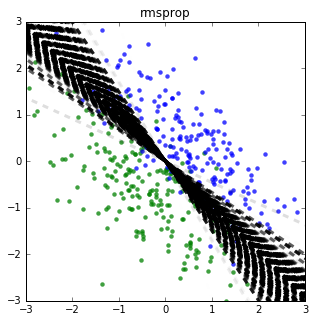

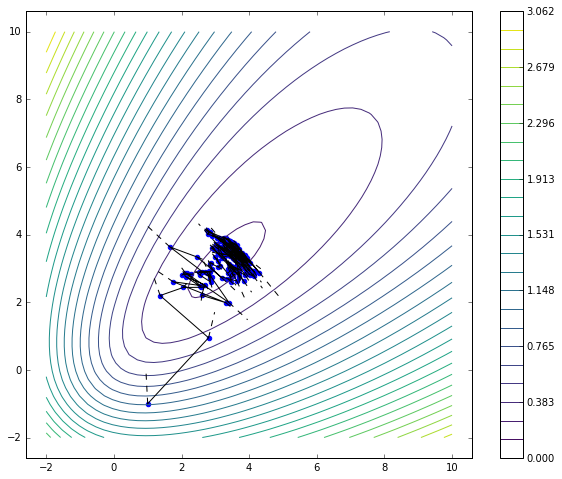

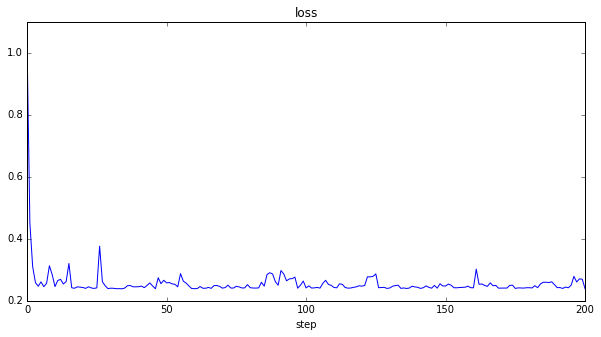

In [38]:
rmsprop_result = rmsprop(lr, X, y, [1.0, -1.0], batch_size=10, learning_rate=0.2, rho=0.99, iters=200)
viz_optimization(rmsprop_result, title='rmsprop')

In [39]:
def adam(problem, X, y, initial_guess, batch_size=10, learning_rate=1.0,
         rho1=0.9, rho2=0.99, delta=1.0e-2, iters=100):

    from scipy.optimize import minimize_scalar

    w = np.array(initial_guess, dtype='float32')

    l = problem.get_loss(X, y, w)
    grad = problem.get_grad(X, y, w)

    yield l, w, grad
    
    v = np.zeros(2, dtype='float32')
    r = np.zeros(2, dtype='float32')

    for i in xrange(iters):
        indx = np.random.choice(X.shape[0], size=batch_size)
        grad = problem.get_grad(X[indx], y[indx], w)
        
        v = rho1 * v + (1.0 - rho1) * grad
        r = rho2 * r + (1.0 - rho2) * (grad ** 2)
        
        d = v / (delta + np.sqrt(r))
        
        w = w - d
        
        l = problem.get_loss(X, y, w)
        
        yield l, w, grad

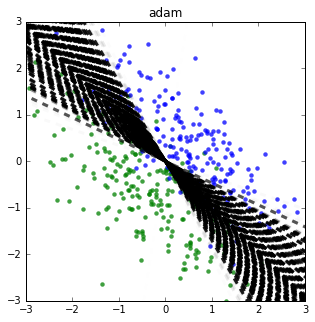

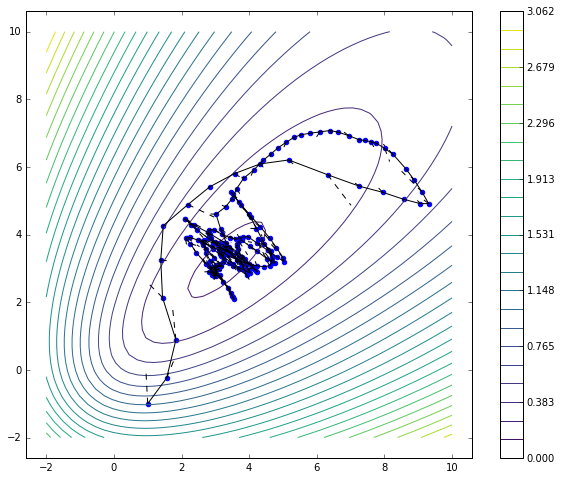

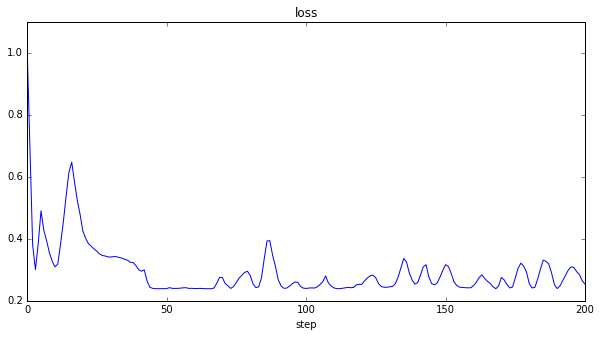

In [40]:
adam_result = adam(lr, X, y, [1.0, -1.0], batch_size=10, iters=200)
viz_optimization(adam_result, title='adam')

## Second-order methods and quasi-Newton methods

In [41]:
def newton(problem, X, y, initial_guess, iters=10):
    from scipy.optimize import minimize_scalar

    w = np.array(initial_guess, dtype='float32')

    l = problem.get_loss(X, y, w)
    grad = problem.get_grad(X, y, w)

    yield l, w, grad

    for i in xrange(iters):
        grad = problem.get_grad(X, y, w)
        H = problem.get_hessian(X, y, w)

        w = w - np.linalg.inv(H).dot(grad)
        
        l = problem.get_loss(X, y, w)
        
        yield l, w, grad

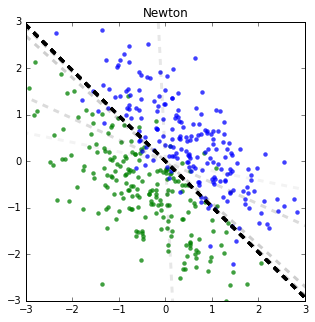

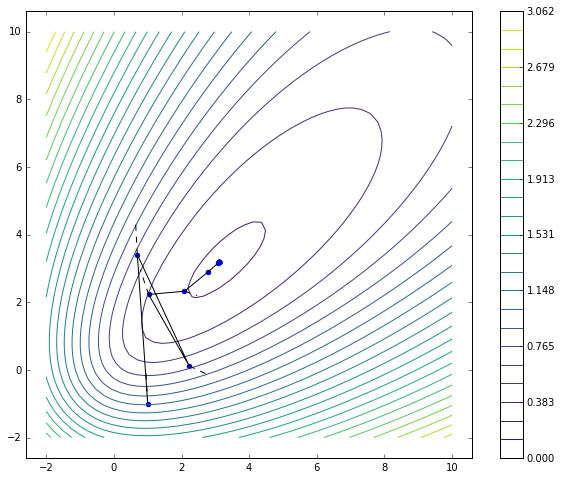

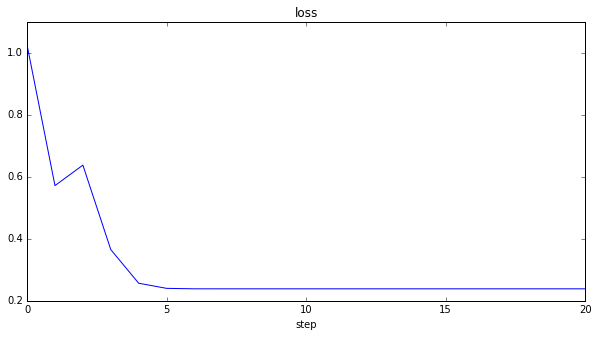

In [42]:
newton_result = newton(lr, X, y, [1.0, -1.0], iters=20)
viz_optimization(newton_result, title='Newton')

In [43]:
def newton_reg(problem, X, y, initial_guess, alpha = 1.0e-1, iters=10):
    from scipy.optimize import minimize_scalar

    w = np.array(initial_guess, dtype='float32')

    l = problem.get_loss(X, y, w)
    grad = problem.get_grad(X, y, w)

    yield l, w, grad

    for i in xrange(iters):
        grad = problem.get_grad(X, y, w)
        H = problem.get_hessian(X, y, w)

        w = w - np.linalg.inv(H + alpha * np.eye(2, dtype='float32')).dot(grad)
        
        l = problem.get_loss(X, y, w)
        
        yield l, w, grad

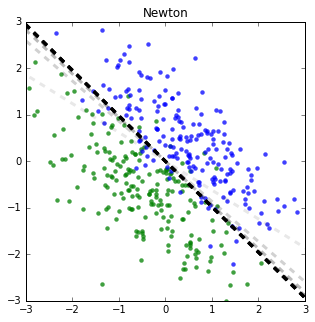

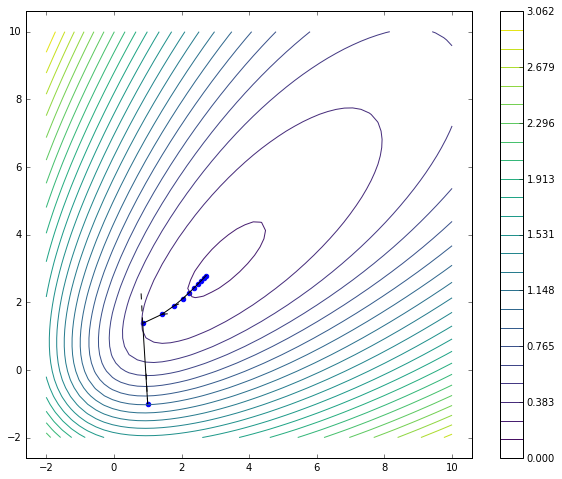

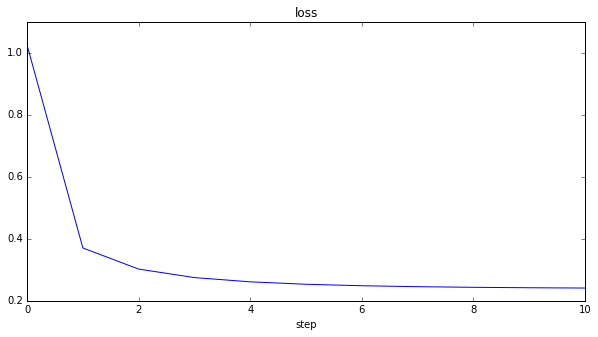

In [44]:
newton_reg_result = newton_reg(lr, X, y, [1.0, -1.0], iters=10)
viz_optimization(newton_reg_result, title='Newton')

In [45]:
def lma(problem, X, y, initial_guess, batch_size= 10, alpha = 1.0e-1, iters=10):
    from scipy.optimize import minimize_scalar

    w = np.array(initial_guess, dtype='float32')

    l = problem.get_loss(X, y, w)
    grad = problem.get_grad(X, y, w)

    yield l, w, grad

    for i in xrange(iters):
        indx = np.random.choice(X.shape[0], size=batch_size)
        
        grad = problem.get_grad(X[indx], y[indx], w)
        H = problem.get_hessian(X[indx], y[indx], w)

        w = w - np.linalg.inv(H + alpha * np.diag(np.diag(H))).dot(grad)
        
        l = problem.get_loss(X, y, w)
        
        yield l, w, grad

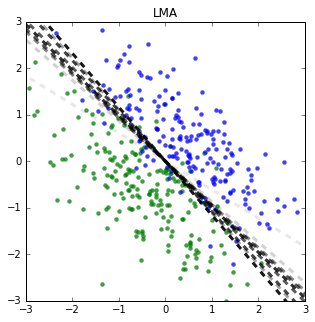

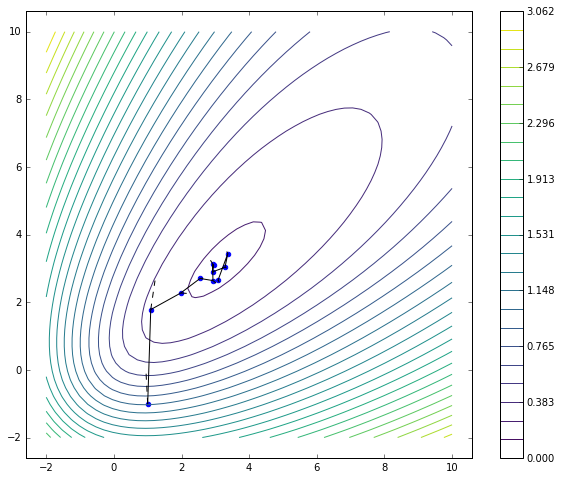

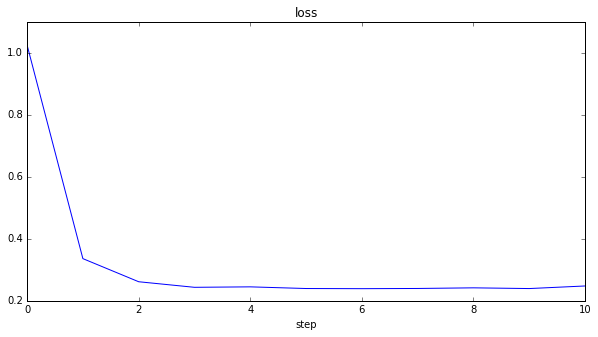

In [46]:
lma_results = lma(lr, X, y, [1.0, -1.0], batch_size=100, iters=10)
viz_optimization(lma_results, title='LMA')

In [47]:
def cg(problem, X, y, initial_guess, bracket_step = 1.0e+2, iters=10):
    from scipy.optimize import minimize_scalar

    w = np.array(initial_guess, dtype='float32')

    l = problem.get_loss(X, y, w)
    grad = problem.get_grad(X, y, w)

    prev_grad = np.zeros(2, dtype='float32')

    yield l, w, grad

    for i in xrange(iters):
        prev_grad = grad
        grad = problem.get_grad(X, y, w)
        
        b = grad.dot(grad) / (prev_grad.dot(prev_grad))
        d = grad + b * prev_grad
        
        alpha = minimize_scalar(
            fun = lambda a: problem.get_loss(X, y, w - a * d),
            bracket=(0.0, bracket_step)
        ).x

        w = w - alpha * d
        
        l = problem.get_loss(X, y, w)
        
        yield l, w, grad

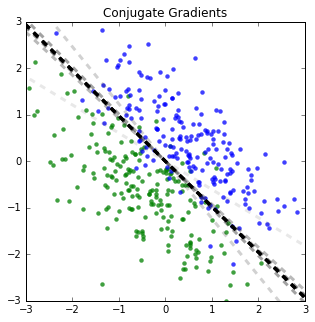

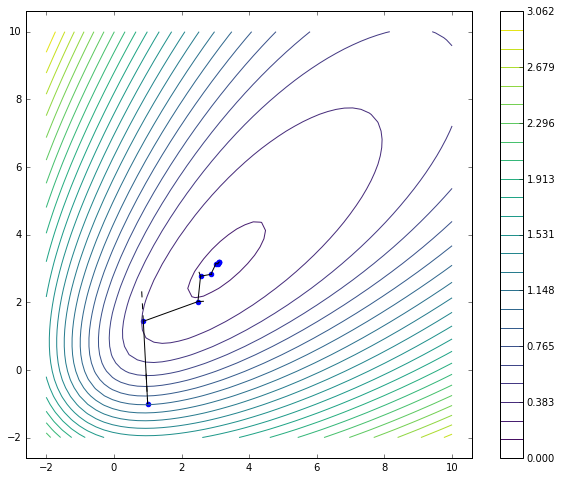

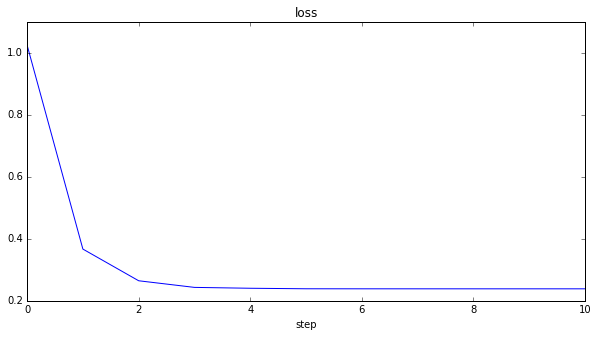

In [48]:
cg_results = cg(lr, X, y, [1.0, -1.0], iters=10)
viz_optimization(cg_results, title='Conjugate Gradients')

In [49]:
def scg(problem, X, y, initial_guess, batch_size=10, bracket_step = 1.0e+2, iters=10):
    from scipy.optimize import minimize_scalar

    w = np.array(initial_guess, dtype='float32')

    l = problem.get_loss(X, y, w)
    grad = problem.get_grad(X, y, w)

    prev_grad = np.zeros(2, dtype='float32')

    yield l, w, grad

    for i in xrange(iters):
        indx = np.random.choice(X.shape[0], size=batch_size)
        prev_grad = grad
        grad = problem.get_grad(X[indx], y[indx], w)
        
        b = grad.dot(grad) / (prev_grad.dot(prev_grad))
        d = grad + b * prev_grad
        
        alpha = minimize_scalar(
            fun = lambda a: problem.get_loss(X[indx], y[indx], w - a * d),
            bracket=(0.0, bracket_step)
        ).x

        w = w - alpha * d
        
        l = problem.get_loss(X, y, w)
        
        yield l, w, grad

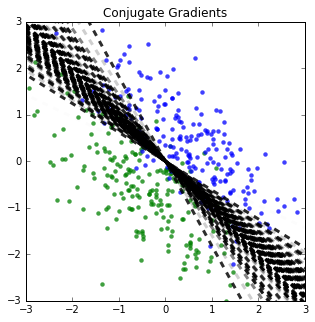

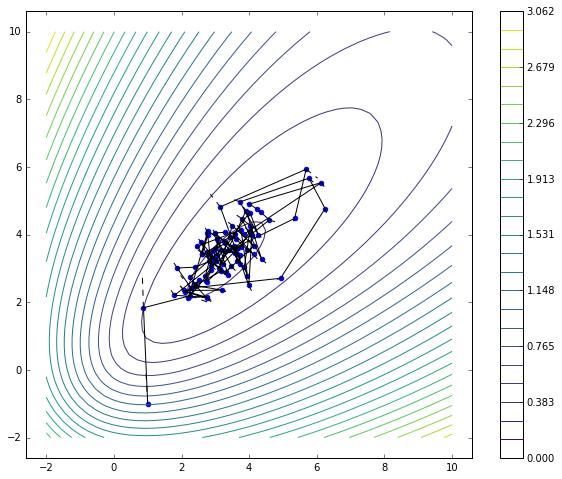

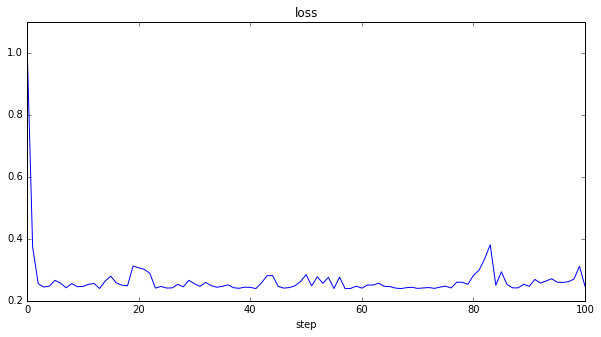

In [50]:
scg_results = scg(lr, X, y, [1.0, -1.0], batch_size=50, iters=100)
viz_optimization(scg_results, title='Conjugate Gradients')